In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
import torch as th

In [2]:
from chromalab.observer import Observer, Cone


In [3]:
from chromalab.observer import Observer, Cone
from chromalab.inks import Neugebauer, InkGamut, CellNeugebauer, Pigment
from chromalab.spectra import Spectra, Illuminant

In [4]:
from chromalab.inks import InkLibrary

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
wavelengths4 = np.arange(380, 781, 4)
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

In [7]:
elevator_illuminant = Spectra(data=np.load("../data/illuminants/elevator.npy"), wavelengths=wavelengths4)

## checking bucket points

In [8]:
from chromalab.inks import bucket_points

In [9]:
points = np.random.random((500000, 4))

In [10]:
from collections import defaultdict

In [11]:
bucket_points(points)

{2667620256.0: [(array([ 80. ,  83.5,  33. ,  79.5]), 4),
  (array([ 80. ,  83.5,  92. ,  79.5]), 172053)],
 2986383554.0: [(array([ 97. ,  76. ,  78.5,  89. ]), 31),
  (array([ 97. ,  76. ,  47.5,  89. ]), 451053)],
 536891398.0: [(array([  3.,  40.,  85.,  16.]), 63),
  (array([  3. ,  40. ,  87.5,  16. ]), 498421)],
 2147501313.0: [(array([  0.5,  34.5,   0.5,  64. ]), 107),
  (array([  0.5,  34.5,  39. ,  64. ]), 193370)],
 905976720.0: [(array([ 72. ,  13.5,  52.5,  27. ]), 132),
  (array([ 72. ,  13.5,  63. ,  27. ]), 183453)],
 1191212973.0: [(array([ 86.5,  59.5,  46.5,  35.5]), 135),
  (array([ 86.5,  59.5,  61.5,  35.5]), 404106)],
 855657879.0: [(array([ 75.5,  38.5,  39. ,  25.5]), 139),
  (array([ 75.5,  38.5,  28.5,  25.5]), 153337)],
 1761622561.0: [(array([ 16.5,  29. ,  70. ,  52.5]), 164),
  (array([ 16.5,  29. ,  99. ,  52.5]), 366120)],
 704657479.0: [(array([ 35.5,  28. ,  82.5,  21. ]), 165),
  (array([ 35.5,  28. ,  51. ,  21. ]), 53680)],
 1593878921.0: [(array(

## kernel density estimation

In [135]:
X.shape

(300, 2)

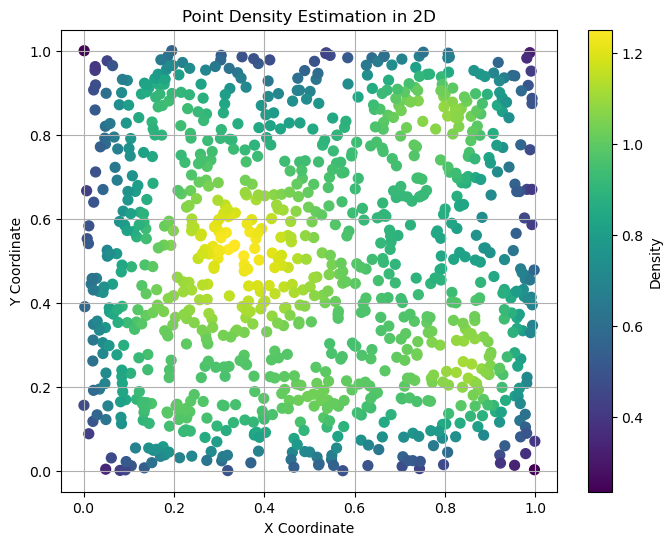

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.datasets import make_circles

N = 300  # number of points
# X, _ = make_circles(n_samples=N, factor=.5, noise=.5)
X = np.random.random((1000, 2))

kde = gaussian_kde(X.T, bw_method='silverman')
densities = kde(X.T)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=densities, cmap='viridis', s=50)
plt.colorbar(scatter, label='Density')
plt.title('Point Density Estimation in 2D')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()


## how does neug look?

In [12]:
cell_primaries = {}
with open(f'../data/nix/11cell.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
    
        cell_primaries[name]  = spectra

In [13]:
cell_neugebauer = CellNeugebauer(cell_primaries)

In [14]:
cell_gamut = InkGamut(cell_neugebauer, illuminant=elevator_illuminant)

In [15]:
def dichromat_gamut(cone1, cone2):
    sm = Observer([cone1(wavelengths10), cone2(wavelengths10)], illuminant=elevator_illuminant)
    pc, _ = cell_gamut.get_point_cloud(sm)
    plt.scatter(pc[:,0], pc[:,1], alpha=0.5)
    for _, s in cell_primaries.items():
        x, y = sm.observe(s)
        plt.scatter(x,y, color='red')

Generating point cloud: 14641it [00:00, 49729.45it/s]


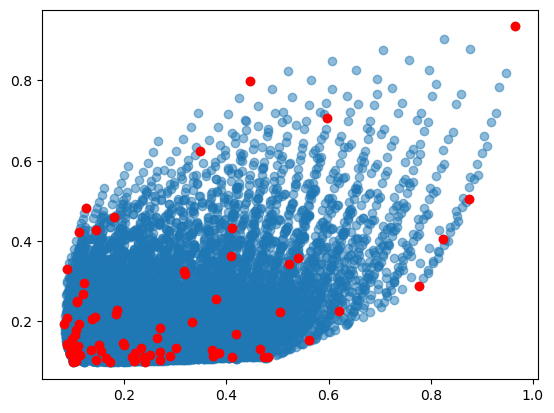

In [16]:
dichromat_gamut(Cone.s_cone, Cone.m_cone)

Generating point cloud: 14641it [00:00, 51257.13it/s]


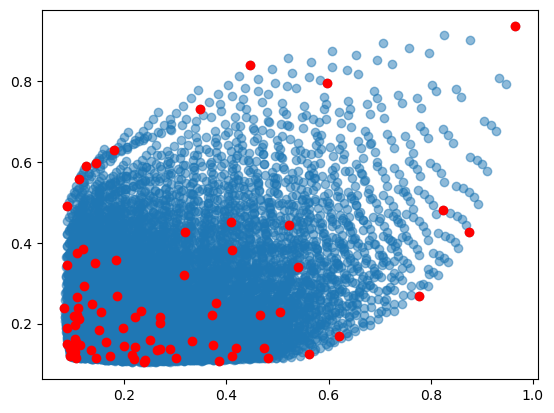

In [17]:
dichromat_gamut(Cone.s_cone, Cone.l_cone)

Generating point cloud: 14641it [00:00, 49646.71it/s]


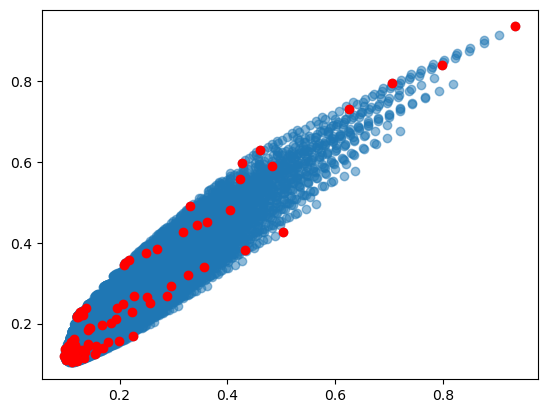

In [18]:
dichromat_gamut(Cone.m_cone, Cone.l_cone)

Generating point cloud: 14641it [00:00, 49236.78it/s]


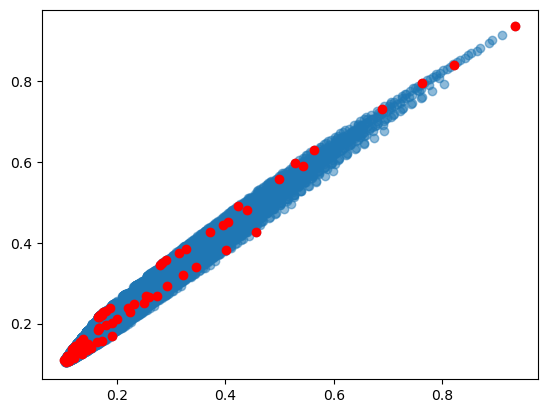

In [19]:
dichromat_gamut(Cone.q_cone, Cone.l_cone)

Generating point cloud: 14641it [00:00, 50188.92it/s]


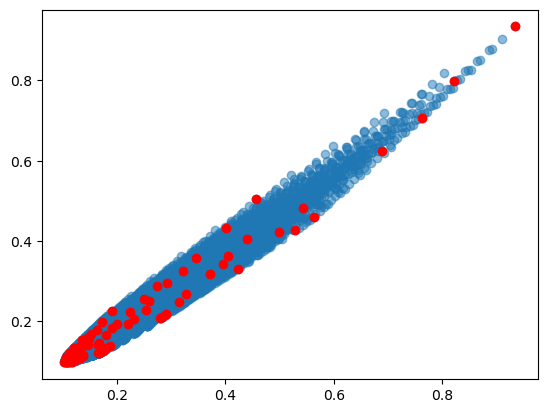

In [20]:
dichromat_gamut(Cone.q_cone, Cone.m_cone)

In [21]:
angle_120 = 2 * np.pi / 3
transform_matrix = np.array([
    [0, 0],
    [1, 0],
    [0.5, np.sqrt(3) / 2]
])

In [22]:
vertices_3d = np.array([
    [1, 0, 0],  # Vertex (1,0,0)
    [0, 1, 0],  # Vertex (0,1,0)
    [0, 0, 1]   # Vertex (0,0,1)
])

In [23]:
vertices_2d = vertices_3d.dot(transform_matrix)

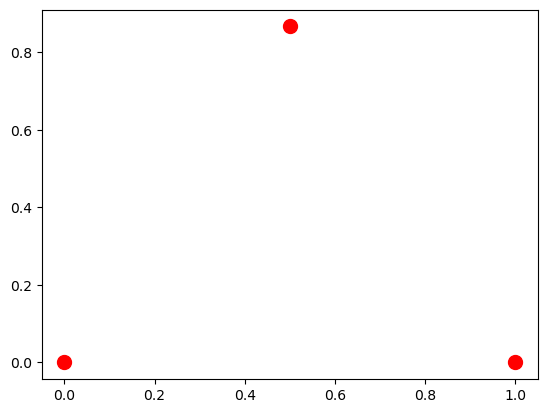

In [24]:
plt.scatter(vertices_2d[:, 0], vertices_2d[:, 1], color='red', s=100)


In [93]:
transform_matrix = np.array([
    [0, 1, 0.5],
    [0, 0, np.sqrt(3) / 2]
])

In [94]:
np.sqrt(3) / 2

0.8660254037844386

In [104]:
def trichromat_gamut(cone1, cone2, cone3):
    sml = Observer([cone1(wavelengths=wavelengths10), cone2(wavelengths=wavelengths10), cone3(wavelengths=wavelengths10)], illuminant=elevator_illuminant)
    abc, _ = cell_gamut.get_point_cloud(sml)
        
#     ab = (transform_matrix @ abc.T).T
    plt.scatter(ab[:,0], ab[:,1], alpha=0.5, color='green') 
    
    for _, s in cell_primaries.items():
        vertex = sml.observe(s)
        x, y = vertex[0] / np.sum(vertex), vertex[1] / np.sum(vertex)
        plt.scatter(x,y,color='red')
        
#     vertices_3d = np.array([
#         [1, 0, 0],  # Vertex (1,0,0)
#         [0, 1, 0],  # Vertex (0,1,0)
#         [0, 0, 1]   # Vertex (0,0,1)
#     ])
#     vertices_2d = vertices_3d.dot(transform_matrix)
#     plt.scatter(vertices_2d[:, 0], vertices_2d[:, 1], color='blue')
    

Generating point cloud: 14641it [00:00, 48519.16it/s]


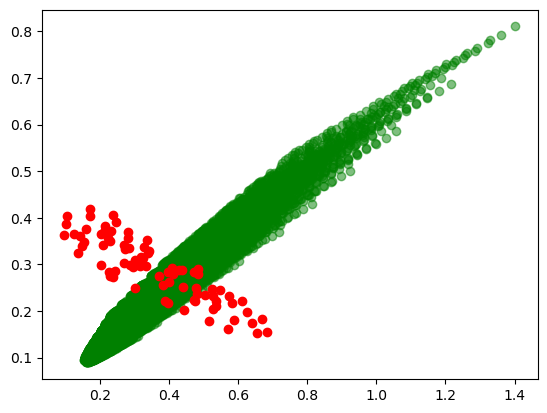

In [105]:
trichromat_gamut(Cone.s_cone, Cone.m_cone, Cone.l_cone)

Generating point cloud: 14641it [00:00, 49984.50it/s]


1.40218775084 0.810627221863
1.21833041667 0.727675190455
0.778950893589 0.512290431235
0.645879499935 0.416236768136
0.588870167131 0.391767521257
0.461431778947 0.33356277032
0.241864263367 0.190570331064
0.23118820272 0.187208740469
0.234027368525 0.190922270775
1.10408059819 0.689892482296
0.991251242161 0.634549837283
0.701687161337 0.482756201915
0.565758101356 0.385594947446
0.529917644832 0.369047372068
0.436583518555 0.325423105521
0.238791374764 0.191430936464
0.229019137383 0.187374026289
0.231183403346 0.189641137569
0.775866860184 0.546587983953
0.726195165892 0.517780783028
0.577375322824 0.42580727098
0.396912323793 0.309728368804
0.385977934257 0.303214576311
0.379690880221 0.298593460014
0.248470946686 0.200848703915
0.24054368474 0.197178624605
0.257595145352 0.206533942685
0.717429143527 0.370612477275
0.623983459361 0.331413532002
0.442266818052 0.252811193336
0.423268853379 0.233095649269
0.380999731477 0.217187900878
0.298122211928 0.182694396741
0.180084394545 0.

ValueError: shapes (3,3) and (2,3) not aligned: 3 (dim 1) != 2 (dim 0)

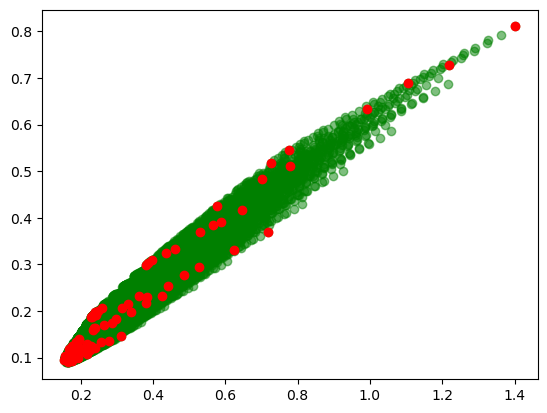

In [101]:
trichromat_gamut(Cone.q_cone, Cone.m_cone, Cone.l_cone)